# Finding Supernova Neutrinos

To date we have only managed to detect the neutrinos from one supernova, which arrived at Earth on the 23rd February 1987 and is known by the snappy name SN1987A. In this project you will investigate the feasibility of idenitfying supernova neutrino events in a new type of detector a liquid argon time-projection chamber. These detectors give incredibly high-resolution 'images' of the charged-particle tracks produced when a neutrino interacts in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| larImages.npy | A numpy array of 10,000 100x100 pixel images |
| meta.npy | The meta information about the particles in the image |


The images show the energy deposited in the liquid argon detector in a small slice of space and time. The meta information contains the following 64 numbers  for each image. The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

print(tf.__version__)
plt.style.use('ggplot')


2.15.0


In [2]:
# Import data
images=np.load('larImages.npy') 
meta=np.load('meta.npy')

print("images.shape",images.shape)
print("meta.shape",meta.shape)

images.shape (10000, 100, 100)
meta.shape (10000, 64)


In [3]:
meta[0].shape

(64,)

In [4]:
print("Row",int(meta[0][0]),"corresponds to a neutrino of",meta[0][1], "MeV and produced",int(meta[0][3]),"final state particles")

Row 0 corresponds to a neutrino of 21.2005 MeV and produced 6 final state particles


## Electronic Noise
Simulate Gaussian distributed electronic noise within the detector.

In [5]:
# Simulate electronic noise
def elecNoise(images,ynoise):
    '''Add Gaussian distributed electronic noise to the images.'''
    '''
    Input
    - images(array): array of images
    - ynoise(float): maximum noise value
    Output
    - MNIST images
    '''
    noise = np.random.normal(0, ynoise, images.shape) # Generate noise from a uniform distribution from 0 to ynoise
    
    return images + noise

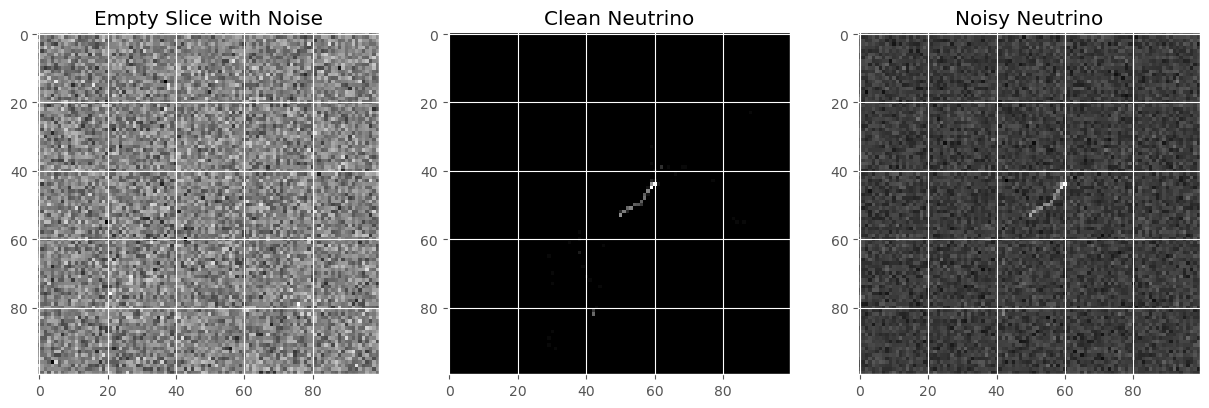

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot empty slice with noise
ax[0].imshow(elecNoise(np.zeros((100,100)),2), cmap='gray')
ax[0].set_title('Empty Slice with Noise')

# Plot clean neutrino
ax[1].imshow(images[380], cmap='gray')
ax[1].set_title('Clean Neutrino')

# Plot noisy neutrino
ax[2].imshow(elecNoise(images[380],2), cmap='gray')
ax[2].set_title('Noisy Neutrino')

plt.savefig('elecnoise.png', dpi=500)
plt.show()

### Classifying Clean Neutrinos

In [7]:
def train_dataset(ynoise):
    '''Create training dataset with clean neutrinos and empty slices with electronic noise.'''
    '''
    Input
        ynoise (float): level of noise
    Output
        train_images (array): images
        train_labels (array): image labels
    '''

    global images

    # Create empty slices with noise
    train_empty_1 = elecNoise(np.zeros((9000, 100, 100)),ynoise)
    train_empty_2 = np.zeros((1000, 100, 100))
    train_empty = np.concatenate((train_empty_1,train_empty_2), axis=0)
    train_labels_0 = np.zeros(train_empty.shape[0]) # Label 0 for the empty slices

    # Create training dataset
    train_labels_1 = np.ones(7000) # Label 1 for the neutrinos
    train_images = np.concatenate((images[:7000, :, :], train_empty), axis=0)
    train_labels = np.concatenate((train_labels_1, train_labels_0), axis=0)

    # Shuffle train dataset
    p = np.random.permutation(train_images.shape[0])
    train_images = train_images[p]
    train_labels = train_labels[p]

    return train_images, train_labels

def classifier(ynoise):
    '''Build and train classifier with clean neutrinos and empty slices with electronic noise.'''
    '''
    Input
        ynoise (float): level of noise
    Output
        classifier (model): trained classifier
    '''

    global images
    
    # Create training dataset
    train_images, train_labels = train_dataset(ynoise)

    # Build classifier using CNN layers
    classifier = keras.Sequential()
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dense(32, activation='relu'))
    classifier.add(keras.layers.Dropout(0.5))  # Dropout layer
    classifier.add(keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    classifier.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    classifier.summary()
    
    # Train classifier
    history=classifier.fit(train_images, train_labels,batch_size=300, epochs=5)

    return classifier

def test_accuracy(ynoise,classifier):
    '''Test accuracy of classifier on test dataset with clean neutrinos and empty slices with electronic noise.'''
    '''
    Input
        ynoise (float): level of noise
        classifier (model): trained classifier
    Output
        test_acc (float): test accuracy of the classifier for the given level of noise
    '''

    global images

    # Create test dataset
    test_empty = elecNoise(np.zeros((3000, 100, 100)),ynoise) # Create 2000 empty slices
    test_labels_0 = np.zeros((test_empty.shape[0])) # Label 0 for the empty slices

    test_labels_1 = np.ones(3000) # Label 1 for the neutrinos
    test_images = np.concatenate((images[-3000:, :, :], test_empty), axis=0)

    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    # Test accuracy
    test_loss, test_acc = classifier.evaluate(test_images,test_labels,verbose=0)
    print(f'Test accuracy on test dataset at {ynoise}:', test_acc)

    return test_acc

def performance(classifier,ynoise):
    '''Evaluate the performance of the classifier on a testing dataset with clean neutrinos and empty slices with electronic noise.'''
    '''
    Input
        classifier (model): trained classifier
        ynoise (float): level of noise
    Output
        fractions of correctly classified neutrinos and noise
    '''

    fractions = {
        'signal_correct': [],
        'noise_correct': [],
        'signal_incorrect': [],
        'noise_incorrect': []
    }
    
    # Create test dataset
    test_empty = elecNoise(np.zeros((3000, 100, 100)),ynoise) # Create 2000 empty slices
    test_labels_0 = np.zeros((test_empty.shape[0])) # Label 0 for the empty slices

    test_labels_1 = np.ones(3000) # Label 1 for the neutrinos
    test_images = np.concatenate((images[-3000:, :, :], test_empty), axis=0)

    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    for i in range(10):

        predictions_prob = classifier.predict(test_images) 
        predictions = (predictions_prob > 0.5).astype(int)
        
        cm = confusion_matrix(test_labels, predictions)
        TN, FP, FN, TP = cm.ravel()
        
        fractions['signal_correct'].append(TP / (TP + FN))
        fractions['noise_correct'].append(TN / (TN + FP))
        fractions['signal_incorrect'].append(FN / (TP + FN))
        fractions['noise_incorrect'].append(FP / (TN + FP))
    
    # Calculate mean fractions
    mean_fractions = {key: np.mean(values) for key, values in fractions.items()}

    print(f"Fraction of signal events correctly classified: {mean_fractions['signal_correct']}")
    print(f"Fraction of noise events correctly classified: {mean_fractions['noise_correct']}")

    return mean_fractions['signal_correct'],mean_fractions['noise_correct']





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16928)             0         
                                                                 
 dense (Dense)               (None, 32)              

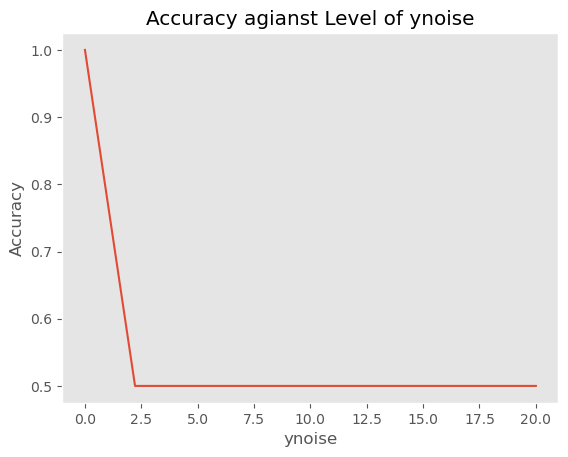

In [8]:
# First test with a model trained with clean slices
c0 = classifier(0) # ynoise = 0

ynoises = np.linspace(0,20,10)
accuracies = []
for i in ynoises:
    accuracies.append(test_accuracy(i,c0))

# Plot result
plt.figure()
plt.title(f'Accuracy agianst Level of ynoise')
plt.xlabel(f'ynoise')
plt.ylabel(f'Accuracy')
plt.grid()
plt.errorbar(ynoises, accuracies, fmt = "-")

plt.savefig('c0accuracies.png', dpi=500)

The model trained on clean slices drops accuracy when ynoise is added, and approaches random guessing.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 16928)             0         
                                                                 
 dense_2 (Dense)             (None, 32)               

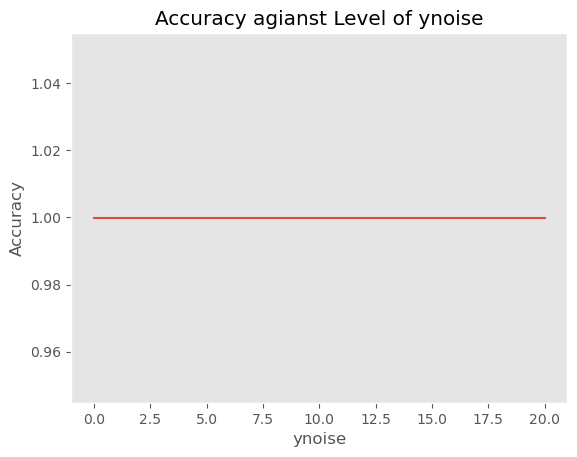

In [9]:
# Train and test a classifier with noise
c1 = classifier(5)

ynoises = np.linspace(0,20,10)
accuracies = []
for i in ynoises:
    accuracies.append(test_accuracy(i,c1))

# Plot result
plt.figure()
plt.title(f'Accuracy agianst Level of ynoise')
plt.xlabel(f'ynoise')
plt.ylabel(f'Accuracy')
plt.grid()
plt.errorbar(ynoises, accuracies, fmt = "-")
plt.savefig('c1accuracies.png', dpi=500)

In [10]:
# Evaluate performance at each noise level
SC_array = []
NC_array = []

for ynoise in ynoises:
    SC_i,NC_i = performance(c1,ynoise)
    SC_array.append(SC_i)
    NC_array.append(NC_i)

188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of n

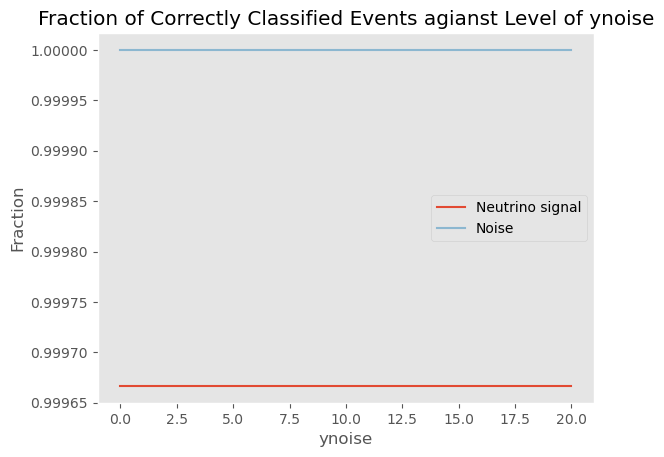

In [11]:
# Plot result
plt.figure()
plt.title(f'Fraction of Correctly Classified Events agianst Level of ynoise')
plt.xlabel(f'ynoise')
plt.ylabel(f'Fraction')
plt.grid()
plt.errorbar(ynoises, SC_array, fmt = "-",label='Neutrino signal')
plt.errorbar(ynoises, NC_array, fmt="-", label='Noise', alpha=0.5)
plt.legend()
plt.savefig('c1frs.png', dpi=500)

The performance of classifier tested on noisy empty slices and clean neutrino images is unaffected by the level of noise added. 

### Classifying Noisy Neutrinos

##### Examine scale of activated pixels in the neutrino images.

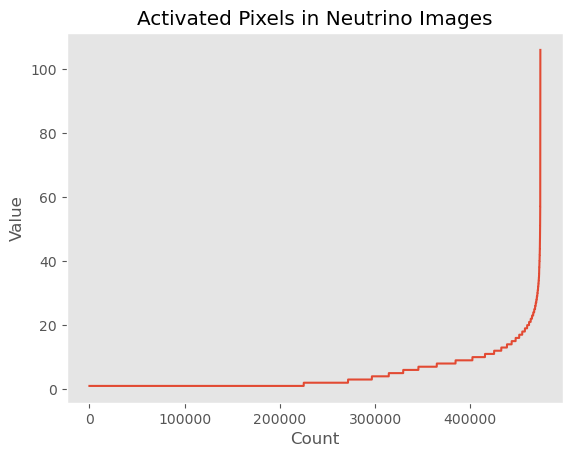

In [12]:
# Looking at the distribution of values
activated_pixels = images[images != 0]

plt.figure()
plt.title(f'Activated Pixels in Neutrino Images')
plt.xlabel(f'Count')
plt.ylabel(f'Value')
plt.grid()
plt.errorbar(np.arange(0,activated_pixels.shape[0],1), np.sort(activated_pixels), fmt = "-")

plt.savefig('activatedscale.png', dpi=500)

In [13]:
# Evaluate the standard deviation of the activated pixels in each image

stds = []
for image in images:
    activated_pixels_1 = image[image != 0] # Extract activated pixels
    stds.append(np.std(activated_pixels_1))

print(f"Std:{np.mean(stds):.1f}")

Std:5.6


The majority of the activated pixles have values below 20. Within each image, the standard deviation of them is around 5.6. Therefore, the level of noise overlaid onto the neutrinos should not exceed this scale.

#### Test classifier with neutrinos overlaid with noise

In [14]:
def test_accuracy_1(ynoise,classifier):
    '''Test accuracy of classifier on test dataset with both neutrinos and empty slices with electronic noise.'''
    '''
    Input
        ynoise (float): level of noise
        classifier (model): trained classifier
    Output
        test_acc (float): test accuracy of the classifier for the given level of noise
    '''
    
    global images

    # Overlay neutrinos with noises
    test_noisy_images = elecNoise(images[-3000:, :, :],ynoise)

    # Create test dataset
    test_empty = elecNoise(np.zeros((3000, 100, 100)),ynoise)
    test_labels_0 = np.zeros((test_empty.shape[0])) # Label 0 for the empty slices

    test_labels_1 = np.ones(3000) # Label 1 for the neutrinos
    test_images = np.concatenate((test_noisy_images, test_empty), axis=0)
    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    # Test accuracy
    test_loss, test_acc = classifier.evaluate(test_images,test_labels,verbose=0)
    #print(f'Test accuracy on test dataset at {ynoise}:', test_acc)

    return test_acc

def performance_1(classifier,ynoise):
    '''Evaluate the performance of the classifier on a testing dataset with both neutrinos and empty slices with electronic noise.'''
    '''
    Input
        classifier (model): trained classifier
        ynoise (float): level of noise
    Output
        fractions of correctly classified neutrinos and noise
    '''

    fractions = {
        'signal_correct': [],
        'noise_correct': [],
        'signal_incorrect': [],
        'noise_incorrect': []
    }
    
    # Overlay neutrinos with noises
    test_noisy_images = elecNoise(images[-3000:, :, :],ynoise)

    # Create test dataset
    test_empty = elecNoise(np.zeros((3000, 100, 100)),ynoise)
    test_labels_0 = np.zeros((test_empty.shape[0])) # Label 0 for the empty slices

    test_labels_1 = np.ones(3000) # Label 1 for the neutrinos
    test_images = np.concatenate((test_noisy_images, test_empty), axis=0)
    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    for i in range(10):
        
        predictions_prob = classifier.predict(test_images)
        predictions = (predictions_prob > 0.5).astype(int)
        
        cm = confusion_matrix(test_labels, predictions)
        TN, FP, FN, TP = cm.ravel()
        
        fractions['signal_correct'].append(TP / (TP + FN))
        fractions['noise_correct'].append(TN / (TN + FP))
        fractions['signal_incorrect'].append(FN / (TP + FN))
        fractions['noise_incorrect'].append(FP / (TN + FP))
    
    # Calculate mean fractions
    mean_fractions = {key: np.mean(values) for key, values in fractions.items()}

    print(f"Fraction of signal events correctly classified: {mean_fractions['signal_correct']}")
    print(f"Fraction of noise events correctly classified: {mean_fractions['noise_correct']}")

    return mean_fractions['signal_correct'],mean_fractions['noise_correct']

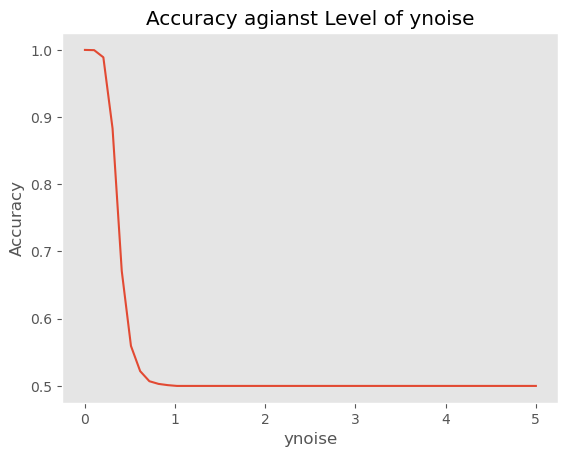

In [15]:
ynoises_1 = np.linspace(0,5,50)
accuracies_1 = []
for i in ynoises_1:
    accuracies_1.append(test_accuracy_1(i,c1))

# Plot result
plt.figure()
plt.title(f'Accuracy agianst Level of ynoise')
plt.xlabel(f'ynoise')
plt.ylabel(f'Accuracy')
plt.grid()
plt.errorbar(ynoises_1, accuracies_1, fmt = "-")
plt.savefig('c1accuracies_noise.png', dpi=500)

In [16]:
# Find the index of the maximum value in the accuracies array
max_index = np.argmax(accuracies_1)

# Retrieve the corresponding ynoise value using the index
max_ynoise = ynoises_1[max_index]

# Retrieve the maximum accuracy value
max_accuracy = accuracies_1[max_index]

# Print the maximum ynoise and accuracy values
print("Maximum Accuracy:", max_accuracy)
print("Corresponding ynoise:", max_ynoise)

Maximum Accuracy: 0.999833345413208
Corresponding ynoise: 0.0


#### Classifier Trained on Neutrinos with Noise

In [17]:
# The classifier needs to be trained on neutrinos overlaid with ynoise

def classifier_1(ynoise):
    '''Build and train classifier on training dataset with both neutrinos and empty slices with electronic noise.'''
    '''
    Input
        ynoise (float): level of noise
    Output
        classifier (model): trained classifier
    '''

    global images

    # Create empty slices with noise
    train_empty_1 = elecNoise(np.zeros((9000, 100, 100)),ynoise)
    train_empty_2 = np.zeros((1000, 100, 100))
    train_empty = np.concatenate((train_empty_1,train_empty_2), axis=0)
    train_labels_0 = np.zeros(train_empty.shape[0]) # Label 0 for the empty slices

    # Create neutrino slices with noise
    noisy_images = elecNoise(images[:7000, :, :],ynoise)

    # Create training dataset
    train_labels_1 = np.ones(7000) # Label 1 for the neutrinos
    train_images = np.concatenate((noisy_images, train_empty), axis=0)
    train_labels = np.concatenate((train_labels_1, train_labels_0), axis=0)

    # Shuffle training dataset
    p = np.random.permutation(train_images.shape[0])
    train_images = train_images[p]
    train_labels = train_labels[p]

    # Build classifier
    classifier = keras.Sequential()
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dense(32, activation='relu'))
    classifier.add(keras.layers.Dropout(0.5))  
    classifier.add(keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    classifier.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    classifier.summary()
    
    # Train classifier
    history=classifier.fit(train_images, train_labels,batch_size=300, epochs=100)

    return classifier

In [ ]:
#c_1 = classifier_1(5) # Train on the typical scale of stdx

In [ ]:
#c_1.save('bdbb.h5')

In [18]:
c_1 = load_model('c2.h5')

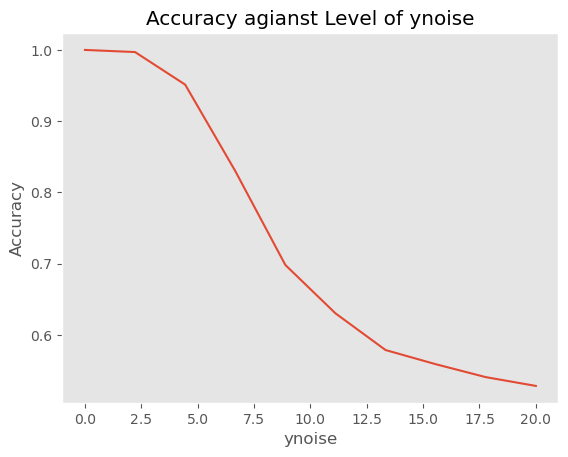

In [19]:
ynoises_1 = np.linspace(0,20,10)
accuracies_1 = []
for i in ynoises_1:
    accuracies_1.append(test_accuracy_1(i,c_1))

# Plot result
plt.figure()
plt.title(f'Accuracy agianst Level of ynoise')
plt.xlabel(f'ynoise')
plt.ylabel(f'Accuracy')
plt.grid()
plt.errorbar(ynoises_1, accuracies_1, fmt = "-")
plt.savefig('c2accuracies.png', dpi=500)

In [20]:
ynoises_1 = np.linspace(0,10,30)
accuracies_1 = []
for i in ynoises_1:
    accuracies_1.append(test_accuracy_1(i,c_1))

<ErrorbarContainer object of 3 artists>

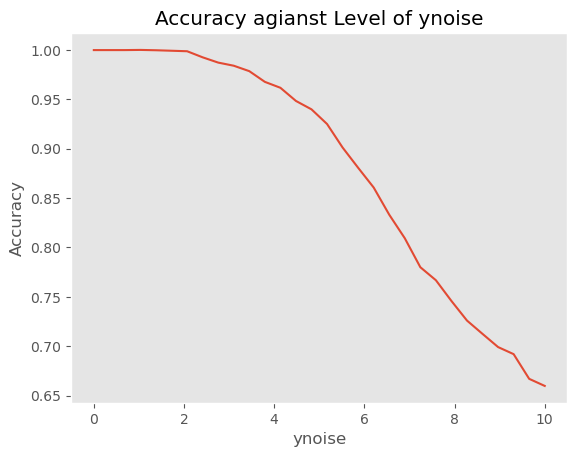

In [21]:
# Plot result
plt.figure()
plt.title(f'Accuracy agianst Level of ynoise')
plt.xlabel(f'ynoise')
plt.ylabel(f'Accuracy')
plt.grid()
plt.errorbar(ynoises_1, accuracies_1, fmt = "-")

The retriained classifier improves significantly, more tolerable against increasing level of noise.

In [22]:
# Evaluate performance at each noise level
SC_array_1 = []
NC_array_1 = []

for ynoise_1 in ynoises_1:
    SC_i_1,NC_i_1 = performance_1(c_1,ynoise_1)
    SC_array_1.append(SC_i_1)
    NC_array_1.append(NC_i_1)

188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9996666666666666
Fraction of noise events correctly classified: 1.0
188/188 [==============================] - 2s 8ms/step
Fraction of signal events correctly classified: 0.9993333333333332
Fraction of n

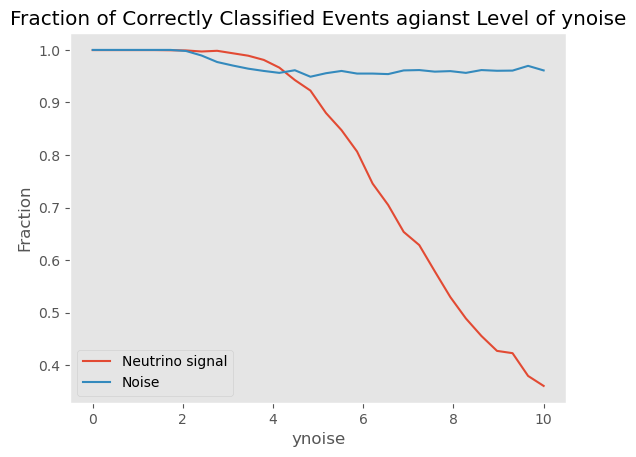

In [23]:
# Plot result
plt.figure()
plt.title(f'Fraction of Correctly Classified Events agianst Level of ynoise')
plt.xlabel(f'ynoise')
plt.ylabel(f'Fraction')
plt.grid()
plt.errorbar(ynoises_1, SC_array_1, fmt = "-",label='Neutrino signal')
plt.errorbar(ynoises_1, NC_array_1, fmt = "-",label='Noise')
plt.legend()
plt.savefig('c2frs.png', dpi=500)

The classifier tends to miss neutrino events when the level of noise increases, while not identifying noise as events.

## Radioactive Noise

Radioactive decays inside liquid argon detectors is another source of noise, which can be simulated as a 3-dimensional gaussian 'blob'. The blob can be represented in a slice in xy plane and another in XZ plane.

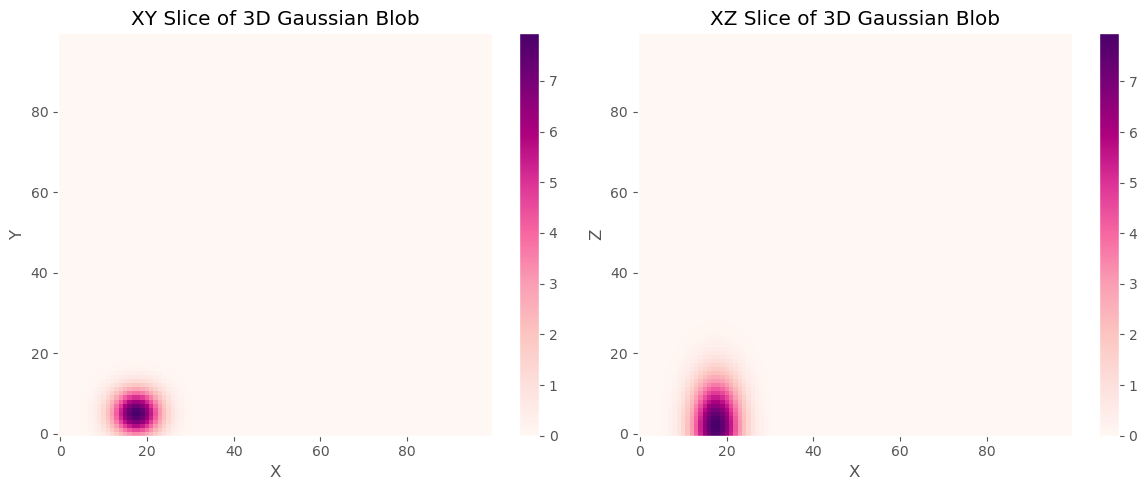

In [24]:
# Parameters for the Gaussian blob
height = 8  # Amplitude
blob_x = np.random.uniform(0, 100)
blob_y = np.random.uniform(0, 100)
blob_z = np.random.uniform(0, 100)
width = 4

# Creating a grid of x and y points for the XY slice
x = np.arange(0, 100, 1)
y = np.arange(0, 100, 1)
X, Y = np.meshgrid(x, y)

# xy slice
xy_slice = height * np.exp(-((X - blob_x)**2 / (2 * width**2) + (Y - blob_y)**2 / (2 * width**2)))

# xz slice (y as z)
xz_slice = height * np.exp(-((X - blob_x)**2 / (2 * width**2) + (Y - blob_z)**2 / (2 * height**2)))

# Plotting the slices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot xy slice
cax1 = ax[0].pcolormesh(X, Y, xy_slice, cmap='RdPu')
fig.colorbar(cax1, ax=ax[0])
ax[0].set_title('XY Slice of 3D Gaussian Blob')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')

# Plot xz slice
cax2 = ax[1].pcolormesh(X, Y, xz_slice, cmap='RdPu')
fig.colorbar(cax2, ax=ax[1])
ax[1].set_title('XZ Slice of 3D Gaussian Blob')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Z')

plt.tight_layout()
plt.savefig('radionoise.png', dpi=500)
plt.show()

In [25]:
def radioNoise(image,width, height):
    '''Add radioactive noise as Gaussian 'blob' to the one image.'''
    '''
    Input
        image (array): original image
    Output
        width (float): width of blob
        height (float): height of blob
    '''
    # Randomly choose the center of the Gaussian 'blob' in 3D space
    blob_x = np.random.uniform(0, 100)
    blob_y = np.random.uniform(0, 100)
    blob_z = np.random.uniform(0, 100)

    # Creating meshgrid
    x = np.arange(0, 100, 1)
    y = np.arange(0, 100, 1)
    X, Y = np.meshgrid(x, y)

    # xy slice
    xy_slice = height * np.exp(-((X - blob_x)**2 / (2 * width**2) + (Y - blob_y)**2 / (2 * width**2)))

    # xz slice (y as z)
    xz_slice = height * np.exp(-((X - blob_x)**2 / (2 * width**2) + (Y - blob_z)**2 / (2 * height**2)))

    return image+xy_slice, image+xz_slice

def train_dataset_radio_clean(width, height):
    '''Create training dataset with both neutrinos and empty slices with random radioactive noise.'''
    '''
    Input
        width (float): width of blob
        height (float): height of blob
    Output
        train_images (array): images
        train_labels (array): image labels
    '''

    global images

    # Create empty slices with noise
    train_empty = np.zeros((3000, 100, 100))
    train_empty_1 = np.zeros((1000, 100, 100))

    radio_empty_1 = []
    radio_empty_2 = []

    for image in train_empty:
        image1, image2 = radioNoise(image,width, height)
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    train_empty = np.concatenate((radio_empty_1, radio_empty_2,train_empty_1), axis=0) 
    train_labels_0 = np.zeros(train_empty.shape[0]) # Label 0 for the empty slices

    # Create training dataset
    train_labels_1 = np.ones(6000) # Label 1 for the neutrinos
    train_images = np.concatenate((images[:6000, :, :], train_empty), axis=0)
    train_labels = np.concatenate((train_labels_1, train_labels_0), axis=0)

    # Shuffle train dataset
    p = np.random.permutation(train_images.shape[0])
    train_images = train_images[p]
    train_labels = train_labels[p]

    return train_images, train_labels


In [26]:
radio_train_images_1, radio_train_labels_1 = train_dataset_radio_clean(10,20)

In [27]:
radio_train_images_1.shape

(13000, 100, 100)

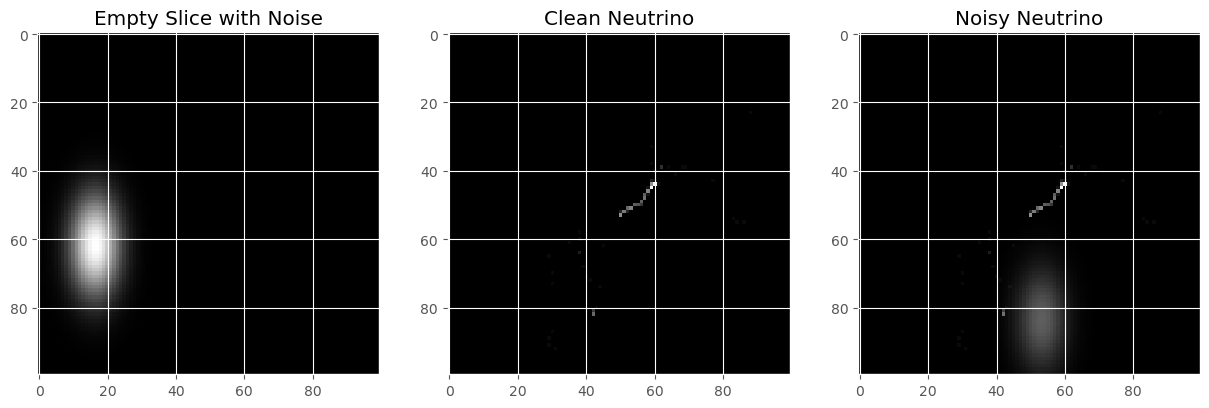

In [28]:
# Setup 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot empty slice with noise
ax[0].imshow(radioNoise(np.zeros((100, 100)),5, 10)[1],cmap='gray')
ax[0].set_title('Empty Slice with Noise')

# Plot clean neutrino
ax[1].imshow(images[380],cmap='gray')
ax[1].set_title('Clean Neutrino')

# Plot noisy neutrino
ax[2].imshow(radioNoise(images[380],5, 10)[1], cmap='gray')
ax[2].set_title('Noisy Neutrino')
plt.savefig('radionoise_images.png', dpi=500)
plt.show()

### Classifying Clean Neutrinos

In [29]:
def classifier_r(width, height):
    '''Build and train classifier on training dataset with clean neutrinos and empty slices with radioactive noise.'''
    '''
    Input
        width (float): width of blob
        height (float): height of blob
    Output
        classifier (model): trained classifier
    '''

    global images
    
    # Create training dataset
    train_images, train_labels = train_dataset_radio_clean(width, height)

    # Build classifier using CNN layers
    classifier = keras.Sequential()
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dense(32, activation='relu'))
    classifier.add(keras.layers.Dropout(0.5))  # Dropout layer
    classifier.add(keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    classifier.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    classifier.summary()
    
    # Train classifier
    history=classifier.fit(train_images, train_labels,batch_size=300, epochs=6)

    return classifier

def test_accuracy_r(width, height,classifier):
    '''Test accuracy of classifier on test dataset with clean neutrinos and empty slices with radioactive noise.'''
    '''
    Input
        width (float): width of blob
        height (float): height of blob
        classifier (model): trained classifier
    Output
        test_acc (float): test accuracy of the classifier for the given width & height of noise
    '''
    global images

    # Create empty slices with noise
    test_empty = np.zeros((2000, 100, 100))

    radio_empty_1 = []
    radio_empty_2 = []

    for image in test_empty:
        image1, image2 = radioNoise(image, width, height)
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    test_empty = np.concatenate((radio_empty_1, radio_empty_2), axis=0) 
    test_labels_0 = np.zeros(test_empty.shape[0]) # Label 0 for the empty slices

    # Create test dataset
    test_labels_1 = np.ones(3000) # Label 1 for the neutrinos
    test_images = np.concatenate((images[-3000:, :, :], test_empty), axis=0)
    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    # Test accuracy
    test_loss, test_acc = classifier.evaluate(test_images,test_labels,verbose=0)
    print(f'Test accuracy on test dataset at width{width} & height{height}:', test_acc)

    return test_acc

def performance_r(classifier, width, height):
    '''Evaluate the performance of the classifier on a testing dataset with clean neutrinos and empty slices with radioactive noise.'''
    '''
    Input
        classifier (model): trained classifier
        width (float): width of blob
        height (float): height of blob
    Output
        fractions of correctly classified neutrinos and noise
    '''

    fractions = {
        'signal_correct': [],
        'noise_correct': [],
        'signal_incorrect': [],
        'noise_incorrect': []
    }
    
    # Create empty slices with noise
    test_empty = np.zeros((2000, 100, 100))

    radio_empty_1 = []
    radio_empty_2 = []

    for image in test_empty:
        image1, image2 = radioNoise(image, width, height)
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    test_empty = np.concatenate((radio_empty_1, radio_empty_2), axis=0) 
    test_labels_0 = np.zeros(test_empty.shape[0]) # Label 0 for the empty slices

    # Create test dataset
    test_labels_1 = np.ones(3000) # Label 1 for the neutrinos
    test_images = np.concatenate((images[-3000:, :, :], test_empty), axis=0)
    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    for i in range(10):

        predictions_prob = classifier.predict(test_images) 
        predictions = (predictions_prob > 0.5).astype(int)
        
        cm = confusion_matrix(test_labels, predictions)
        TN, FP, FN, TP = cm.ravel()
        
        fractions['signal_correct'].append(TP / (TP + FN))
        fractions['noise_correct'].append(TN / (TN + FP))
        fractions['signal_incorrect'].append(FN / (TP + FN))
        fractions['noise_incorrect'].append(FP / (TN + FP))
    
    # Calculate mean fractions
    mean_fractions = {key: np.mean(values) for key, values in fractions.items()}

    print(f"Fraction of signal events correctly classified: {mean_fractions['signal_correct']}")
    print(f"Fraction of noise events correctly classified: {mean_fractions['noise_correct']}")

    return mean_fractions['signal_correct'],mean_fractions['noise_correct']

In [30]:
c_r_0 = classifier_r(2, 5)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 16928)             0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [31]:
performance_r(c_r_0, 0, 0)

C:\Users\Koukaze\AppData\Local\Temp\ipykernel_16420\2479106998.py:21: RuntimeWarning: divide by zero encountered in divide
  xy_slice = height * np.exp(-((X - blob_x)**2 / (2 * width**2) + (Y - blob_y)**2 / (2 * width**2)))
C:\Users\Koukaze\AppData\Local\Temp\ipykernel_16420\2479106998.py:24: RuntimeWarning: divide by zero encountered in divide
  xz_slice = height * np.exp(-((X - blob_x)**2 / (2 * width**2) + (Y - blob_z)**2 / (2 * height**2)))


219/219 [==============================] - 4s 18ms/step
Fraction of signal events correctly classified: 1.0
Fraction of noise events correctly classified: 1.0


(1.0, 1.0)

In [32]:
test_accuracy_r(2,2,c_r_0)

Test accuracy on test dataset at width2 & height2: 1.0


1.0

In [33]:
width_array = np.linspace(1,40,5)
height_array = np.linspace(1,40,5)

In [34]:
result_array = np.zeros((len(width_array),len(height_array))) # Create array to store data

# Loop through 
for i in range(len(width_array)):
    # Loop through 
    for j in range(len(height_array)):
            result_array[i,j] = test_accuracy_r(width_array[i],height_array[j],c_r_0)

Test accuracy on test dataset at width1.0 & height1.0: 1.0
Test accuracy on test dataset at width1.0 & height10.75: 0.9937142729759216
Test accuracy on test dataset at width1.0 & height20.5: 0.9814285635948181
Test accuracy on test dataset at width1.0 & height30.25: 0.9747142791748047
Test accuracy on test dataset at width1.0 & height40.0: 0.963857114315033
Test accuracy on test dataset at width10.75 & height1.0: 1.0
Test accuracy on test dataset at width10.75 & height10.75: 1.0
Test accuracy on test dataset at width10.75 & height20.5: 1.0
Test accuracy on test dataset at width10.75 & height30.25: 1.0
Test accuracy on test dataset at width10.75 & height40.0: 1.0
Test accuracy on test dataset at width20.5 & height1.0: 1.0
Test accuracy on test dataset at width20.5 & height10.75: 1.0
Test accuracy on test dataset at width20.5 & height20.5: 1.0
Test accuracy on test dataset at width20.5 & height30.25: 1.0
Test accuracy on test dataset at width20.5 & height40.0: 1.0
Test accuracy on test d

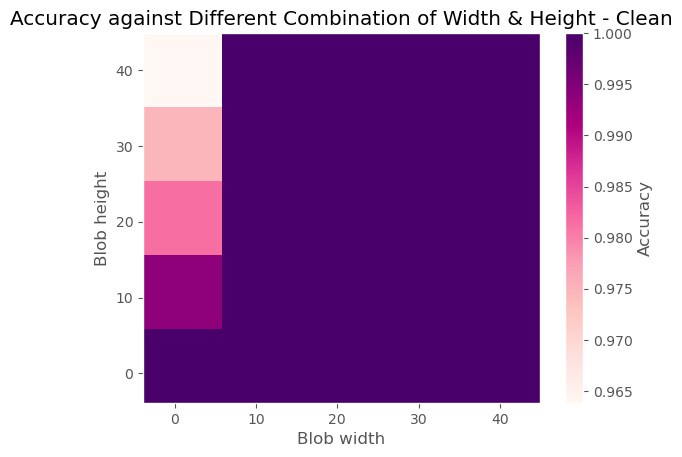

In [35]:
W,H = np.meshgrid(width_array,height_array,indexing = 'ij')

plt.figure()

c = plt.pcolormesh(W, H, result_array, cmap='RdPu')  # Create plot
plt.colorbar(c, label='Accuracy') # Add colour bar

plt.xlabel('Blob width')
plt.ylabel('Blob height')
plt.title('Accuracy against Different Combination of Width & Height - Clean')

plt.savefig('cr0accuracies.png', dpi=500,bbox_inches='tight')
plt.show()

With clean neutrinos, the classifier only loses small accuracy for elongated blobs, with small widths and large heights.

### Classifying Noisy Neutrinos
#### Test classifier with neutrinos overlaid with noise

In [36]:
def test_accuracy_r_1(width, height,classifier):
    '''Test accuracy of classifier on test dataset with both neutrinos and empty slices with radioactive noise.'''
    '''
    Input
        width (float): width of blob
        height (float): height of blob
        classifier (model): trained classifier
    Output
        test_acc (float): test accuracy of the classifier for the given width & height of noise
    '''
    
    global images

    # Overlay neutrinos with noises
    radio_neutrino_1 = []
    radio_neutrino_2 = []

    for image in images[-2000:, :, :]:
        image1, image2 = radioNoise(image, width, height)
        radio_neutrino_1.append(image1)
        radio_neutrino_2.append(image2)
    
    radio_neutrino_1 = np.array(radio_neutrino_1)
    radio_neutrino_2 = np.array(radio_neutrino_2)

    test_noisy_images = np.concatenate((radio_neutrino_1, radio_neutrino_2), axis=0)
    test_labels_1 = np.ones(len(test_noisy_images)) # Label 1 for the neutrinos

    # Create empty slices with noise
    test_empty = np.zeros((2000, 100, 100))

    radio_empty_1 = []
    radio_empty_2 = []

    for image in test_empty:
        image1, image2 = radioNoise(image, width, height)
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    test_empty = np.concatenate((radio_empty_1, radio_empty_2), axis=0) 
    test_labels_0 = np.zeros(test_empty.shape[0]) # Label 0 for the empty slices


    # Create test dataset
    test_images = np.concatenate((test_noisy_images, test_empty), axis=0)
    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    # Test accuracy
    test_loss, test_acc = classifier.evaluate(test_images,test_labels,verbose=0)
    #print(f'Test accuracy on test dataset at {ynoise}:', test_acc)

    return test_acc

def performance_r_1(classifier,width,height):
    '''Evaluate the performance of the classifier on a testing dataset with both neutrinos and empty slices with radioactive noise.'''
    '''
    Input
        classifier (model): trained classifier
        width (float): width of blob
        height (float): height of blob
    Output
        fractions of correctly classified neutrinos and noise
    '''

    fractions = {
        'signal_correct': [],
        'noise_correct': [],
        'signal_incorrect': [],
        'noise_incorrect': []
    }
    
    # Overlay neutrinos with noises
    radio_neutrino_1 = []
    radio_neutrino_2 = []

    for image in images[-2000:, :, :]:
        image1, image2 = radioNoise(image, width, height)
        radio_neutrino_1.append(image1)
        radio_neutrino_2.append(image2)
    
    radio_neutrino_1 = np.array(radio_neutrino_1)
    radio_neutrino_2 = np.array(radio_neutrino_2)

    test_noisy_images = np.concatenate((radio_neutrino_1, radio_neutrino_2), axis=0)
    test_labels_1 = np.ones(len(test_noisy_images)) # Label 1 for the neutrinos

    # Create empty slices with noise
    test_empty = np.zeros((2000, 100, 100))

    radio_empty_1 = []
    radio_empty_2 = []

    for image in test_empty:
        image1, image2 = radioNoise(image, width, height)
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    test_empty = np.concatenate((radio_empty_1, radio_empty_2), axis=0) 
    test_labels_0 = np.zeros(test_empty.shape[0]) # Label 0 for the empty slices


    # Create test dataset
    test_images = np.concatenate((test_noisy_images, test_empty), axis=0)
    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]

    for i in range(10):
        # Simulate different test conditions here, e.g., by adding random noise
        # X_test_modified = X_test + np.random.normal(0, noise_level, X_test.shape)
        
        predictions_prob = classifier.predict(test_images)  # Assuming X_test is already prepared for the current sibloblation
        predictions = (predictions_prob > 0.5).astype(int)
        
        cm = confusion_matrix(test_labels, predictions)
        TN, FP, FN, TP = cm.ravel()
        
        fractions['signal_correct'].append(TP / (TP + FN))
        fractions['noise_correct'].append(TN / (TN + FP))
        fractions['signal_incorrect'].append(FN / (TP + FN))
        fractions['noise_incorrect'].append(FP / (TN + FP))
    
    # Calculate mean fractions
    mean_fractions = {key: np.mean(values) for key, values in fractions.items()}

    print(f"Fraction of signal events correctly classified: {mean_fractions['signal_correct']}")
    print(f"Fraction of noise events correctly classified: {mean_fractions['noise_correct']}")

    return mean_fractions['signal_correct'],mean_fractions['noise_correct']

In [37]:
result_array = np.zeros((len(width_array),len(height_array))) # Create array to store data

# Loop through 
for i in range(len(width_array)):
    # Loop through 
    for j in range(len(height_array)):
            result_array[i,j] = test_accuracy_r_1(width_array[i],height_array[j],c_r_0)

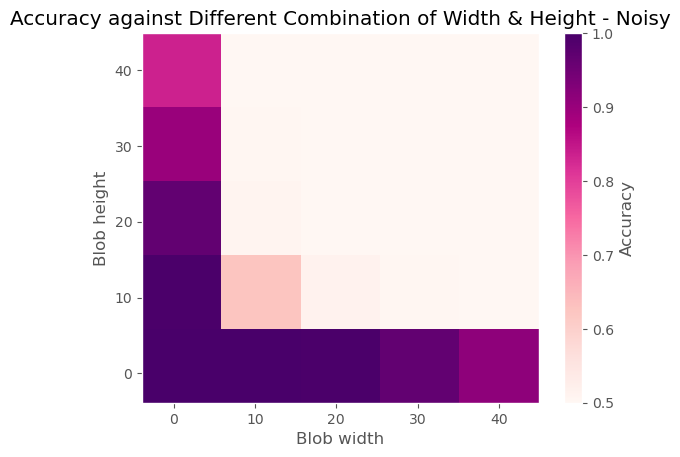

In [41]:
W,H = np.meshgrid(width_array,height_array,indexing = 'ij')

plt.figure()

c = plt.pcolormesh(W, H, result_array, cmap='RdPu')  # Create plot
plt.colorbar(c, label='Accuracy') # Add colour bar

plt.xlabel('Blob width',)
plt.ylabel('Blob height')
plt.title('Accuracy against Different Combination of Width & Height - Noisy')
plt.savefig('cr0accuracies_noise.png', dpi=500,bbox_inches='tight')
plt.show()

For the classifier trained on clean neutrinos, testing accuaracy on noisy neutrinos approaches random guessing quickly. Retrain a classifier.

#### Classifier Trained on Neutrinos with Noise

In [43]:
# The classifier needs to be trained on neutrinos overlaid with ynoise

def classifier_r_1(width,height):
    '''Build and train classifier on training dataset with both neutrinos and empty slices with radioactive noise.'''
    '''
    Input
        width (float): width of blob
        height (float): height of blob
    Output
        classifier (model): trained classifier
    '''

    global images

    # Overlay neutrinos with noises
    radio_neutrino_1 = []
    radio_neutrino_2 = []

    for image in images[:5000, :, :]:
        image1, image2 = radioNoise(image, width, height)
        radio_neutrino_1.append(image1)
        radio_neutrino_2.append(image2)
    
    radio_neutrino_1 = np.array(radio_neutrino_1)
    radio_neutrino_2 = np.array(radio_neutrino_2)

    train_noisy_images = np.concatenate((radio_neutrino_1, radio_neutrino_2), axis=0)
    train_labels_1 = np.ones(len(train_noisy_images)) # Label 1 for the neutrinos


    # Create empty slices with noise
    train_empty = np.zeros((4000, 100, 100))
    train_empty_1 = np.zeros((3000, 100, 100))

    radio_empty_1 = []
    radio_empty_2 = []

    for image in train_empty:
        image1, image2 = radioNoise(image, width, height)
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    train_empty = np.concatenate((radio_empty_1, radio_empty_2,train_empty_1), axis=0) 
    train_labels_0 = np.zeros(train_empty.shape[0]) # Label 0 for the empty slices


    # Create training dataset
    train_images = np.concatenate((train_noisy_images, train_empty), axis=0)
    train_labels = np.concatenate((train_labels_1, train_labels_0), axis=0)

    # Shuffle train dataset
    p = np.random.permutation(train_images.shape[0])
    train_images = train_images[p]
    train_labels = train_labels[p]


    # Build classifier
    classifier = keras.Sequential()
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dense(32, activation='relu'))
    classifier.add(keras.layers.Dropout(0.5))  
    classifier.add(keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    classifier.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    classifier.summary()

    # Train classifier
    history=classifier.fit(train_images, train_labels,batch_size=300, epochs=6)

    return classifier

In [44]:
# Train 3 classifiers with different combinations
c_r_1_1 = classifier_r_1(5,20)
c_r_1_2 = classifier_r_1(10,5)
c_r_1_3 = classifier_r_1(15,15)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 16928)             0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [45]:
# Create width and height arrays for testing
width_array = np.linspace(1,40,5)
height_array = np.linspace(1,40,5)

In [46]:
result_array_1 = np.zeros((len(width_array),len(height_array))) # Create array to store data

# Loop through width
for i in range(len(width_array)):
    # Loop through height
    for j in range(len(height_array)):
            result_array_1[i,j] = test_accuracy_r_1(width_array[i],height_array[j],c_r_1_1)

result_array_2 = np.zeros((len(width_array),len(height_array))) # Create array to store data

# Loop through width
for i in range(len(width_array)):
    # Loop through height
    for j in range(len(height_array)):
            result_array_2[i,j] = test_accuracy_r_1(width_array[i],height_array[j],c_r_1_2)

result_array_3 = np.zeros((len(width_array),len(height_array))) # Create array to store data

# Loop through width
for i in range(len(width_array)):
    # Loop through height
    for j in range(len(height_array)):
            result_array_3[i,j] = test_accuracy_r_1(width_array[i],height_array[j],c_r_1_3)

In [47]:
result_array_plots = np.stack((result_array_1, result_array_2, result_array_3), axis=0)

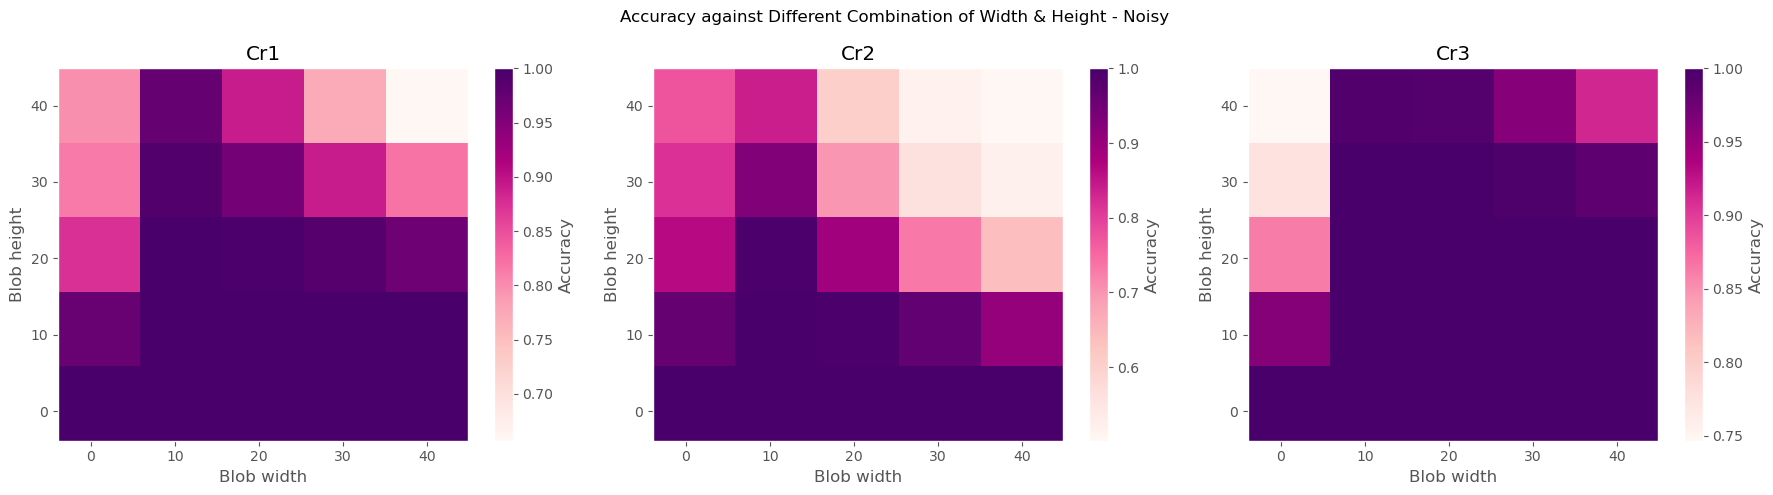

In [48]:
W,H = np.meshgrid(width_array,height_array,indexing = 'ij')

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Accuracy against Different Combination of Width & Height - Noisy')
for i in range(3):
    cax = axs[i].pcolormesh(W, H, result_array_plots[i, :, :], cmap='RdPu')
    fig.colorbar(cax, ax=axs[i], label='Accuracy')
    axs[i].set_xlabel(f'Blob width')
    axs[i].set_ylabel(f'Blob height')
    axs[i].set_title(f'Cr{i+1}')

plt.savefig('crsaccuracies.png', dpi=500,bbox_inches='tight')
plt.tight_layout()

- All three classifiers obtain good accuracy for all combinations when general level is low. Despite unavoidable decrease of accuracy for high level noise covering the neutrino signals, the classifers all experience difficulties when classifying elongated radioactive noise. 

- In the chamber, there exists low energy beta emitters, for example $^{39}Cl$, $^{39}Ar$, $^{35}S$, typically depositis energy of a few keV. $^{39}Cl$ has typical decay energy of around 3 MeV, but there also exists more energetic radioactive noise, like $^{36}Ar$ captures which can produce around 9 MeV gamma cascades. Therefore, the radioloactive noises can be a problem.

#### Misclassified Images
To see what types of images are more likely to be misclassified, train and test a model with blobs of random widths and heights.

In [49]:
def train_dataset_radio_noisy():
    '''Create training dataset with both neutrinos and empty slices with random radioactive noise.'''
    '''
    Output
        train_images (array): images
        train_labels (array): image labels
    '''

    global images

    # Overlay neutrinos with noises
    radio_neutrino_1 = []
    radio_neutrino_2 = []

    for image in images[:5000, :, :]:
        image1, image2 = radioNoise(image, np.random.uniform(0.01,40), np.random.uniform(0.01,40)) # Overlay a blob with random width and height
        radio_neutrino_1.append(image1)
        radio_neutrino_2.append(image2)
    
    radio_neutrino_1 = np.array(radio_neutrino_1)
    radio_neutrino_2 = np.array(radio_neutrino_2)

    train_noisy_images = np.concatenate((radio_neutrino_1, radio_neutrino_2), axis=0)
    train_labels_1 = np.ones(len(train_noisy_images)) # Label 1 for the neutrinos


    # Create empty slices with noise
    train_empty = np.zeros((4000, 100, 100))
    train_empty_1 = np.zeros((3000, 100, 100))

    radio_empty_1 = []
    radio_empty_2 = []

    for image in train_empty:
        image1, image2 = radioNoise(image, np.random.uniform(0.01,40), np.random.uniform(0.01,40))
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    train_empty = np.concatenate((radio_empty_1, radio_empty_2,train_empty_1), axis=0) 
    train_labels_0 = np.zeros(train_empty.shape[0]) # Label 0 for the empty slices


    # Create training dataset
    train_images = np.concatenate((train_noisy_images, train_empty), axis=0)
    train_labels = np.concatenate((train_labels_1, train_labels_0), axis=0)

    return train_images, train_labels


def test_dataset_radio_noisy():
    '''Create testing dataset with both neutrinos and empty slices with random radioactive noise.'''
    '''
    Output
        test_images (array): images
        test_labels (array): image labels
        test_meta (array): image meta information
    '''
    
    global images

    # Overlay neutrinos with noises
    radio_neutrino_1 = []
    radio_neutrino_2 = []

    for image in images[-2000:, :, :]:
        image1, image2 = radioNoise(image, np.random.uniform(0.01,40), np.random.uniform(0.01,40))
        radio_neutrino_1.append(image1)
        radio_neutrino_2.append(image2)
    
    radio_neutrino_1 = np.array(radio_neutrino_1)
    radio_neutrino_2 = np.array(radio_neutrino_2)

    test_noisy_images = np.concatenate((radio_neutrino_1, radio_neutrino_2), axis=0)
    meta_1 = np.concatenate((meta[-2000:, :],meta[-2000:, :]), axis=0) # Include meta information
    test_labels_1 = np.ones(len(test_noisy_images)) # Label 1 for the neutrinos

    # Create empty slices with noise
    test_empty = np.zeros((2000, 100, 100))
    meta_empty = np.zeros((2000, 64))
    radio_empty_1 = []
    radio_empty_2 = []

    for image in test_empty:
        image1, image2 = radioNoise(image, np.random.uniform(0.01,40), np.random.uniform(0.01,40))
        radio_empty_1.append(image1)
        radio_empty_2.append(image2)

    radio_empty_1 = np.array(radio_empty_1)
    radio_empty_2 = np.array(radio_empty_2)

    test_empty = np.concatenate((radio_empty_1, radio_empty_2), axis=0) 
    meta_2 = np.concatenate((meta_empty,meta_empty), axis=0)
    test_labels_0 = np.zeros(test_empty.shape[0]) # Label 0 for the empty slices


    # Create test dataset
    test_images = np.concatenate((test_noisy_images, test_empty), axis=0)
    test_labels = np.concatenate((test_labels_1, test_labels_0), axis=0)
    test_meta = np.concatenate((meta_1,meta_2), axis=0)

    # Shuffle test dataset
    p = np.random.permutation(test_images.shape[0])
    test_images = test_images[p]
    test_labels = test_labels[p]
    test_meta = test_meta[p]

    return test_images, test_labels, test_meta

def classifier_R():
    '''
    Create and train a classifier for random radioactive noise.
    '''
    '''
    Output
        classifier (model)
    '''

    train_images, train_labels = train_dataset_radio_noisy()
    
    # Build classifier
    classifier = keras.Sequential()
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    classifier.add(keras.layers.MaxPooling2D((2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dense(32, activation='relu'))
    classifier.add(keras.layers.Dropout(0.5))  
    classifier.add(keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    classifier.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    classifier.summary()

    # Train classifier
    history=classifier.fit(train_images, train_labels,batch_size=300, epochs=6)

    return classifier

def test_accuracy_R(classifier):
    '''Test accuracy of classifier on test dataset with both neutrinos and empty slices with random radioactive noise.'''
    '''
    Input
        classifier (model): trained classifier
    Output
        test_acc (float): test accuracy of the classifier for the given width & height of noise
    '''
    
    global images

    # Create test dataset
    test_images, test_labels, test_meta = test_dataset_radio_noisy()

    # Test accuracy
    test_loss, test_acc = classifier.evaluate(test_images,test_labels,verbose=0)
    #print(f'Test accuracy on test dataset at {ynoise}:', test_acc)

    return test_acc


def performance_R(classifier):
    '''Evaluate the performance of the classifier on a testing dataset with both neutrinos and empty slices with random radioactive noise.'''
    '''
    Input
        classifier (model): trained classifier
    Output
        fractions of correctly classified neutrinos and noise
    '''

    fractions = {
        'signal_correct': [],
        'noise_correct': [],
        'signal_incorrect': [],
        'noise_incorrect': []
    }
    
    # Create test dataset
    test_images, test_labels, test_meta = test_dataset_radio_noisy()

    for i in range(10):
        # Simulate different test conditions here, e.g., by adding random noise
        # X_test_modified = X_test + np.random.normal(0, noise_level, X_test.shape)
        
        predictions_prob = classifier.predict(test_images)  # Assuming X_test is already prepared for the current sibloblation
        predictions = (predictions_prob > 0.5).astype(int)
        
        cm = confusion_matrix(test_labels, predictions)
        TN, FP, FN, TP = cm.ravel()
        
        fractions['signal_correct'].append(TP / (TP + FN))
        fractions['noise_correct'].append(TN / (TN + FP))
        fractions['signal_incorrect'].append(FN / (TP + FN))
        fractions['noise_incorrect'].append(FP / (TN + FP))
    
    # Calculate mean fractions
    mean_fractions = {key: np.mean(values) for key, values in fractions.items()}

    print(f"Fraction of signal events correctly classified: {mean_fractions['signal_correct']}")
    print(f"Fraction of noise events correctly classified: {mean_fractions['noise_correct']}")

    return mean_fractions['signal_correct'],mean_fractions['noise_correct']

In [50]:
c_R = classifier_R() # Create classifier

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 16928)             0         
                                                                 
 dense_12 (Dense)            (None, 32)               

In [51]:
test_accuracy_R(c_R) # Test accuracy

0.9991250038146973

In [52]:
performance_R(c_R) # Evaluate performance

250/250 [==============================] - 2s 7ms/step
Fraction of signal events correctly classified: 0.999
Fraction of noise events correctly classified: 0.99925


(0.999, 0.99925)

In [53]:
# Find out which images are incorrectly classified

all_misclassified_neutrino_images = []
all_misclassified_neutrino_meta = []
all_misclassified_empty_images = []

for i in range(5): # Test 5 times
    test_images_E, test_labels_E, test_meta = test_dataset_radio_noisy()

    # Predict probabilities
    predicted_probs = c_R.predict(test_images_E)

    # Convert probabilities to binary labels based on a threshold (0.5 by default)
    predicted_labels = (predicted_probs > 0.5).astype(int).flatten()

    # Find misclassified samples
    misclassified_indices = np.where(predicted_labels != test_labels_E)[0]

    # For misclassified neutrinos (true label is 1 but predicted as 0)
    misclassified_neutrinos_indices = misclassified_indices[test_labels_E[misclassified_indices] == 1]
    misclassified_neutrinos_images = test_images_E[misclassified_neutrinos_indices]
    misclassified_neutrinos_meta = test_meta[misclassified_neutrinos_indices]

    # For misclassified empty slices (true label is 0 but predicted as 1)
    misclassified_empty_indices = misclassified_indices[test_labels_E[misclassified_indices] == 0]
    misclassified_empty_images = test_images_E[misclassified_empty_indices]


    all_misclassified_neutrino_images.append(misclassified_neutrinos_images)
    all_misclassified_neutrino_meta.append(misclassified_neutrinos_meta)
    all_misclassified_empty_images.append(misclassified_empty_images)

misclassified_neutrino_images_array = np.concatenate(all_misclassified_neutrino_images, axis=0)
misclassified_neutrino_meta_array = np.concatenate(all_misclassified_neutrino_meta, axis=0)
misclassified_empty_images_array = np.concatenate(all_misclassified_empty_images, axis=0)

250/250 [==============================] - 2s 7ms/step


In [54]:
misclassified_neutrino_images_array.shape # How many neutrinos are misclassified

(36, 100, 100)

In [64]:
misclassified_empty_images_array.shape # How many empty images are misclassified

(11, 100, 100)

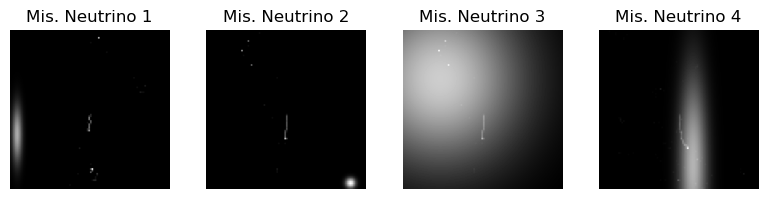

In [66]:
# Plot misclassified neutrino images
fig, ax = plt.subplots(1, 4, figsize=(8, 2))

titles = [f'Mis. Neutrino {i+1}' for i in range(4)]

for i in range(4): 
    ax[i].imshow(misclassified_neutrino_images_array[np.random.randint(0, len(misclassified_neutrino_images_array))], cmap='gray') # Randomly select 4
    ax[i].set_title(titles[i], fontsize=12)
    ax[i].axis('off')

plt.tight_layout()
plt.savefig('incorrectneutrino_R.png', dpi=500, bbox_inches='tight') # Save the plot
plt.show()

In [56]:
# Print meta information for the misclassified neutrinos
for i in range(len(misclassified_neutrino_images_array)):
    print(f"Image{i} corresponds to a neutrino of {misclassified_neutrino_meta_array[i][1]} MeV and produced {int(misclassified_neutrino_meta_array[i][3])} final state particles")

Image0 corresponds to a neutrino of 22.4735 MeV and produced 3 final state particles
Image1 corresponds to a neutrino of 17.1376 MeV and produced 4 final state particles
Image2 corresponds to a neutrino of 27.5675 MeV and produced 5 final state particles
Image3 corresponds to a neutrino of 27.5675 MeV and produced 5 final state particles
Image4 corresponds to a neutrino of 29.0474 MeV and produced 5 final state particles
Image5 corresponds to a neutrino of 45.0138 MeV and produced 6 final state particles
Image6 corresponds to a neutrino of 42.2549 MeV and produced 5 final state particles
Image7 corresponds to a neutrino of 34.0752 MeV and produced 7 final state particles
Image8 corresponds to a neutrino of 12.0513 MeV and produced 3 final state particles
Image9 corresponds to a neutrino of 12.0513 MeV and produced 3 final state particles
Image10 corresponds to a neutrino of 45.0138 MeV and produced 6 final state particles
Image11 corresponds to a neutrino of 17.1376 MeV and produced 4 

Covered events, and low energy events are misclassified frequently.

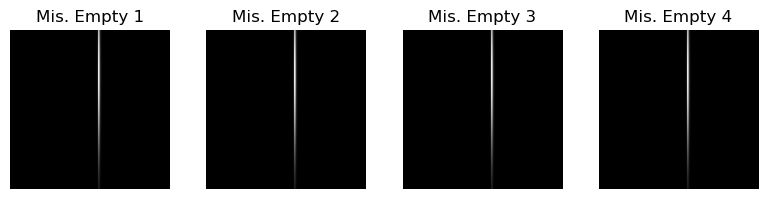

In [65]:
# Plot misclassified empty images
fig, ax = plt.subplots(1, 4, figsize=(8, 2))

titles = [f'Mis. Empty {i+1}' for i in range(4)]

for i in range(4):
    img = misclassified_empty_images[np.random.randint(0, len(misclassified_empty_images))] # Randomly select 4
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(titles[i], fontsize=12)
    ax[i].axis('off')

plt.tight_layout()
plt.savefig('incorrectempty.png', dpi=500, bbox_inches='tight') # Save the image
plt.show()

Elongated noises are misclassified frequently.

## Conclusion

A typical level of electronic noise for LArTPCs is 7.3 MeV. C2 at this level has a test accuracy of above 0.8, with ~95% of neutrino and ~70% of empty images correctly classified. 

For the radioactive noise analysis, all Cr classifiers experienced difficulties for elongated noise blobs of heights $\geq$ 10 MeV. This specific threshold aligns with the energy profiles of $^{36}Ar$ captures, known to generate gamma cascades around 9 MeV, indicating that radiological background substantially impacts the algorithm's effectiveness.